In [1]:
## Import base classes
import numpy as np
import random
import sys, os

# For Interactive Plotting
from viz_util import interactive_plotting
from collections import deque
import matplotlib.pyplot as plt

# For Environment import 
import sys, os
sys.path.append(os.path.abspath('..'))
from environment.grid import GridEnv, Action
from enum import Enum

# For converting during training
import torch
import torch.nn as nn
import torch.nn.functional as F

# For training
from utilities import transpose_list, transpose_to_tensor

[[ 2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 22.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 11.  0.  0.  0.  0.]]
([[0.5, 0.375, 0.375, 0.875], [0.125, 0.0, 0.125, 0.125]], [-1, -1], False)
----
[(4, 3), (1, 0)]
[(3, 7), (1, 1)]


In [2]:
%load_ext autoreload
%autoreload 2
# For Agent import
from multi import MADDPG

In [3]:
# --- Create Environment --- #
def create_environment(name):
    if "taxi-grid":
        env = GridEnv(num_agent = 2)
    state_space, action_space, num_agent = env.state_space, env.action_space, env.num_agent
    ##possible_actions = Action(Enum())

    print("--- Environment {} has been loaded. ---".format(name))
    print("State size: {} | Action size: {} | Number of Agents: {}".format(state_space, action_space, num_agent))
    ##print("Possible Actions: {}".format(possible_actions))
    return env, state_space, action_space.n, num_agent##, possible_actions

# --- Check example outputs --- #
def example_env_output(env):
    next_states, rewards, done = env.step([0, 1])
    print("State: ", next_states)
    print("Reward: ", rewards)
    print("Done: ", done)

In [4]:
# state_size, action_size, num_agent, possible_actions = create_environment("taxi-grid")
env, state_size, action_size, num_agent = create_environment("taxi-grid")

--- Environment taxi-grid has been loaded. ---
State size: 8 | Action size: Discrete(4) | Number of Agents: 2


In [5]:
example_env_output(env)

State:  [[0.875, 0.625, 0.25, 0.0], [0.375, 0.25, 0.25, 0.5]]
Reward:  [-1, -1]
Done:  False


In [6]:
# Create Environment
agents = MADDPG(state_size=int(state_size/num_agent), action_size=action_size, random_seed = 1, num_agent=num_agent)


--- Agent 0 Params ---
Going to train on cpu
Learning Rate:: Actor: 0.0001 | Critic: 0.001
Replay Buffer:: Buffer Size: 100000 | Sampled Batch size: 24

--- Agent 1 Params ---
Going to train on cpu
Learning Rate:: Actor: 0.0001 | Critic: 0.001
Replay Buffer:: Buffer Size: 100000 | Sampled Batch size: 24


In [7]:
def DDPG_eval(agents, env, max_t=100):
    states = env.reset()                                   # reset the environment & get the current state (for each agent)
    cum_scores = np.zeros(num_agent)                           # initialize the score (for each agent)
    scores = []
    episode_length = 0                                     # measure number of steps allowed before done flag
    for i in range(max_t):
        # actions = np.random.randn(num_agents, action_size) # select an action (for each agent); randomly!
        actions = agents.act([torch.from_numpy(np.array(state)).float() for state in states])           # select an action (for each agent)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        next_states, rewards, dones = env.step([np.random.choice(action_size, p=agent_action_prob.numpy()) for agent_action_prob in actions])     # send all actions to the environment, get next_state, rewards and done
        cum_scores += rewards                                  # update the score (for each agent)
        scores.append(cum_scores.copy()[0])
        states = next_states                               # roll over states to next time step
        episode_length +=1
        ##print(env.render(), end='\r')
        #interactive_plotting(scores)
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode length is {}'.format(episode_length))
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(cum_scores)))

In [8]:
DDPG_eval(agents, env, 1)

Episode length is 1
Total score (averaged over agents) this episode: -1.0
c:\Users\danie\Code\ai\udacity-nano\research company\multi-taxi-drl\agent_new\policy.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [11]:
def DDPG_simple_train(agents, env, max_t=100, n_episodes=1):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=20)  # last 100 scores

    for i_episode in range(n_episodes):
        states = env.reset()                                   # reset the environment & get the current state (for each agent)
        cum_scores = np.zeros(num_agent)                           # initialize the score (for each agent)


        for i in range(max_t):
            actions = agents.act([torch.from_numpy(np.array(state)).float() for state in states])           # select an action (for each agent)
            next_states, rewards, dones = env.step([np.random.choice(action_size, p=agent_action_prob.numpy()) for agent_action_prob in actions])   
            cum_scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step

            agents.step(states, actions, rewards, next_states, dones)

            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores.append(cum_scores.copy())
        scores_window.append(cum_scores[0].copy())
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
        # print("\r", 'Episode length is {}'.format(episode_length),  end="")
        # print("\r", 'Total score (averaged over agents) {} episode: {}'.format(np.mean(cum_scores))), end="")

    return scores

In [12]:
new_agents = MADDPG(state_size=int(state_size/num_agent), action_size=action_size, random_seed = 1, num_agent=num_agent)

scores = DDPG_simple_train(new_agents, env, 30, 2000)


--- Agent 0 Params ---
Going to train on cpu
Learning Rate:: Actor: 0.0001 | Critic: 0.001
Replay Buffer:: Buffer Size: 100000 | Sampled Batch size: 24

--- Agent 1 Params ---
Going to train on cpu
Learning Rate:: Actor: 0.0001 | Critic: 0.001
Replay Buffer:: Buffer Size: 100000 | Sampled Batch size: 24
Episode 1999	Average Score: -30.00

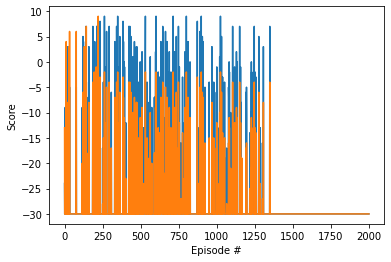

In [13]:
#interactive_plotting(scores, 100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()